# Replica Exchange Monte Carlo using PyStan

In [1]:
import pickle

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns

from matplotlib import cm 
from mpl_toolkits.mplot3d import Axes3D 
from pystan import StanModel 
from scipy.stats import multivariate_normal

In [2]:
np.random.seed(1234)
plt.style.use('seaborn-whitegrid')
sns.set_palette('hls')

## Posterior

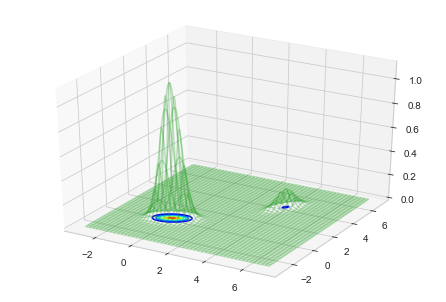

In [3]:
A1 = 0.9 ## ratio of GMM
A2 = 0.1 

grid = np.meshgrid(np.arange(-3, 7, 0.005), np.arange(-3, 7, 0.005))
z = A1*multivariate_normal.pdf(mean=[0, 0], cov=[[0.2, 0.2], [0.06, 0.1]], x=np.c_[grid[0].reshape(-1), grid[1].reshape(-1)])
z += A2*multivariate_normal.pdf(mean=[4, 4], cov=[[0.1, 0.02], [0.1, 0.2]], x=np.c_[grid[0].reshape(-1), grid[1].reshape(-1)])

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(grid[0], grid[1], z.reshape(grid[0].shape), color="tab:green", alpha=0.3)
ax.contour(grid[0], grid[1], z.reshape(grid[0].shape), zdir="z", offset=0.001, cmap=cm.jet)
plt.show()

## stanmodel

In [4]:
stancode = """
data {
  real beta;
}

parameters {
  vector[2] p;
}

model {
  vector[2] mu1;
  vector[2] mu2;
  matrix[2, 2] cov1;
  matrix[2, 2] cov2;

  for (d in 1:2) {
    mu1[d] = 0.0;
    mu2[d] = 4.0;
  }
  cov1[1][1] = 0.2; cov1[1][2] = 0.0; cov1[2][1] = 0.0; cov1[2][2] = 0.2;
  cov2[1][1] = 0.2; cov2[1][2] = 0.0; cov2[2][1] = 0.0; cov2[2][2] = 0.2;

  target += beta * log_sum_exp(
    log(0.9) + multi_normal_lpdf(p | mu1, cov1),
    log(0.1) + multi_normal_lpdf(p | mu2, cov2)
  );
}

"""

In [5]:
filename = "./model/gmm-posterior-PT.pickle"
try:
    with open(filename, mode="rb") as f:
        stanmodel = pickle.load(f)
except FileNotFoundError:
    stanmodel = StanModel(model_code=stancode)
    with open(filename, mode="wb") as g:
        pickle.dump(stanmodel, g)

## MCMC#1 - normal

In [6]:
fit = stanmodel.sampling(data = {"beta":1.0}, iter=2000, warmup=1000, chains=4)
ms = fit.extract()

In [7]:
E = fit.extract(pars="lp__")
ms = fit.extract(pars="p")

In [8]:
ms["p"].shape

(4000, 2)

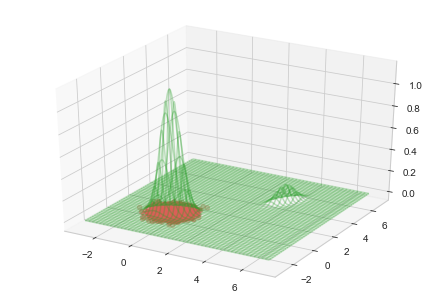

In [9]:
fig = plt.figure()
fig.tight_layout()
ax = Axes3D(fig)

ax.plot_wireframe(grid[0], grid[1], z.reshape(grid[0].shape), color="tab:green", alpha=0.3)
ax.scatter(ms["p"][100:,0], ms["p"][100:,1], alpha=0.3)
plt.show()

## MCMC#2 - replica_exchange (not parallel)

In [10]:
from stanRepEx import ReplicaExchange

In [11]:
%%time
data = {}
init = [{"p":np.array([0.0, 0.0])}]

N_rep = 30 ## number of replicas
N_ex = 200 ## number of exchanges
Inv_T = 0.5 ** np.linspace(0, -np.log(0.2)/np.log(2), num=N_rep)

replica_exchange = ReplicaExchange(n_ex=N_ex, inv_T=Inv_T, stanmodel=stanmodel)
result = replica_exchange.sampling(data=data, par_init=dict(p=np.array([0, 0])), n_iter=70, warmup=50)

CPU times: user 57.6 s, sys: 484 ms, total: 58.1 s
Wall time: 1min 7s


In [12]:
Inv_T

array([1.        , 0.94601405, 0.89494258, 0.84662825, 0.80092222,
       0.75768368, 0.7167794 , 0.67808338, 0.64147641, 0.60684569,
       0.57408455, 0.54309205, 0.51377271, 0.4860362 , 0.45979708,
       0.43497449, 0.41149198, 0.3892772 , 0.3682617 , 0.34838074,
       0.32957307, 0.31178076, 0.29494898, 0.27902588, 0.2639624 ,
       0.24971214, 0.23623119, 0.22347802, 0.21141335, 0.2       ])

## Result

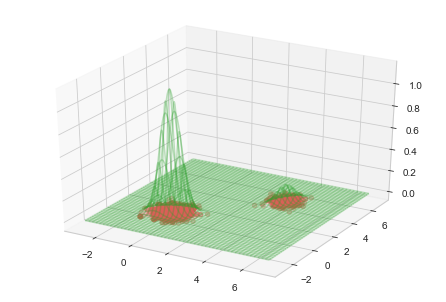

In [13]:
fig = plt.figure()
fig.tight_layout()
ax = Axes3D(fig)

ax.plot_wireframe(grid[0], grid[1], z.reshape(grid[0].shape), color="tab:green", alpha=0.3)
ax.scatter(result[0][100:,0], result[0][100:,1], alpha=0.3)
plt.show()

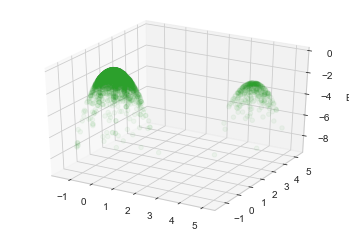

In [14]:
df = pd.DataFrame({"p0":result[0][100:,0], "p1":result[0][100:,1], "E":result[0][100:,2]})

td = plt.figure().gca(projection="3d")
td.scatter(df["p0"], df["p1"], df["E"], color="tab:green", alpha=0.05)
td.set_zlabel('E')
plt.show()

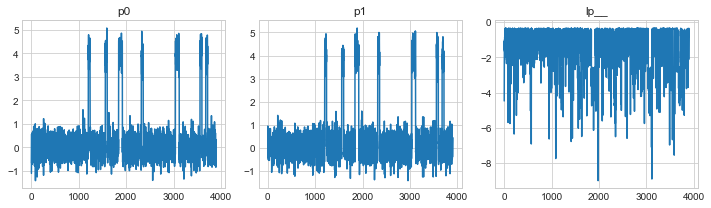

In [15]:
params = ["p0", "p1", "lp__"]
fig, ax = plt.subplots(1, 3, figsize=(10,3))
for ii in range(3):
    ax[ii].set_title(params[ii])
    ax[ii].plot(result[0][100:,ii], color="tab:blue")
fig.tight_layout()
plt.show()

## MCMC#3 - replica_exchange (parallel)

In [16]:
from stanRepEx import ReplicaExchangeParallel

In [17]:
%%time
data = {}
init = [{"p":np.array([0.0, 0.0])}]

N_rep = 30 ## number of replicas
N_ex = 200 ## number of exchanges
Inv_T = 0.5 ** np.linspace(0, -np.log(0.2)/np.log(2), num=N_rep)

replica_exchange_para = ReplicaExchangeParallel(n_ex=N_ex, inv_T=Inv_T, stanmodel=stanmodel)
result_para = replica_exchange.sampling(data=data, par_init=dict(p=np.array([0, 0])), n_iter=70, warmup=50)

CPU times: user 57.8 s, sys: 498 ms, total: 58.3 s
Wall time: 1min 11s


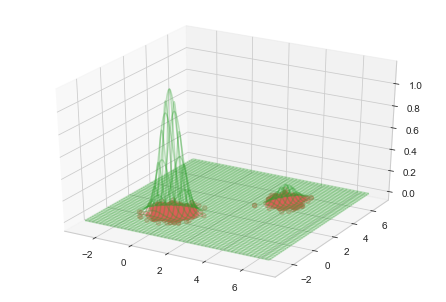

In [18]:
fig = plt.figure()
fig.tight_layout()
ax = Axes3D(fig)

ax.plot_wireframe(grid[0], grid[1], z.reshape(grid[0].shape), color="tab:green", alpha=0.3)
ax.scatter(result_para[0][100:,0], result_para[0][100:,1], alpha=0.3)
plt.show()

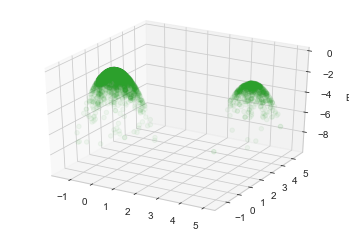

In [19]:
df_para = pd.DataFrame({"p0":result_para[0][100:,0], "p1":result_para[0][100:,1], "E":result_para[0][100:,2]})

td = plt.figure().gca(projection="3d")
td.scatter(df_para["p0"], df_para["p1"], df_para["E"], color="tab:green", alpha=0.05)
td.set_zlabel('E')
plt.show()

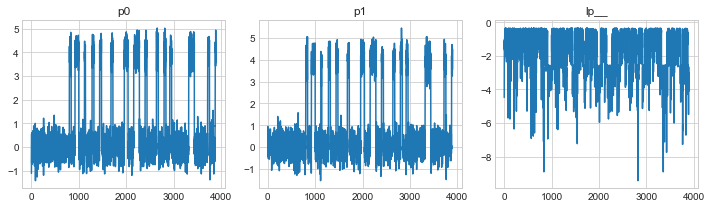

In [20]:
params = ["p0", "p1", "lp__"]
fig, ax = plt.subplots(1, 3, figsize=(10,3))
for ii in range(3):
    ax[ii].set_title(params[ii])
    ax[ii].plot(result_para[0][100:,ii], color="tab:blue")
fig.tight_layout()
plt.show()